<a href="https://colab.research.google.com/github/chirag2saraiya/TSAI-DeepVision-EVA4/blob/master/04-Face-Recognition-Part-2/s4_face_recognition_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Downgrade pytorch and torchvision to get models compatible with aws deployment
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 30kB/s 
     |████████████████████████████████| 6.5MB 1.3MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# copy the mtcnn aligned dataset
!cp /content/drive/My\ Drive/e4p2s4/mtcnn_aligned_dataset.zip  ./

In [3]:
# Extract the dataset
!unzip -q mtcnn_aligned_dataset.zip 

In [4]:
# install facenet-pytorch package. This package has the pretrained resnet-v1 model we need
!pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 6.5MB/s 


In [1]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import torchvision
from facenet_pytorch import InceptionResnetV1
import cv2
from PIL import Image
import PIL
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from torchsummary import summary
import json

## Dataset Creation

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/mtcnn_aligned_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,  shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

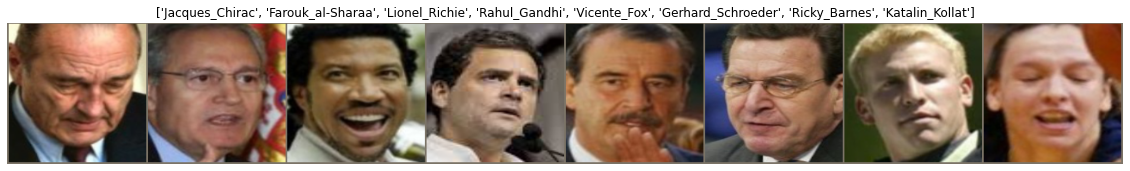

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

plt.figure(figsize=(20, 10))
plt.axis('off')
imshow(out, title=[class_names[x] for x in classes[:8]])
plt.show()

In [9]:
with open('lfw_plus_politicians_classnames.json', 'w') as json_file:
  json.dump(class_names, json_file)

## Create the Model for Transfer Learning

In [3]:
from facenet_pytorch import InceptionResnetV1
device = torch.device("cuda:0")
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = len(class_names))

Running on device: cuda:0


In [4]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=5759, bias=True)]

In [ ]:
model_ft

In [5]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [6]:
for param in model_ft.parameters():
    param.requires_grad = False

In [7]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
        
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [8]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize())
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
#model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)

In [ ]:
summary(model_ft, input_size=(3, 160, 160))

In [14]:
!pip install torch-lr-finder

In [20]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-1, momentum=0.9)# Decay LR by a factor of *gamma* every *step_size* epochs
lr_finder = LRFinder (model_ft,optimizer_ft,criterion,device=device)

In [21]:
lr_finder.range_test(dataloaders['train'],start_lr= 1,end_lr= 1e-11)


Learning rate search finished. See the graph with {finder_name}.plot()


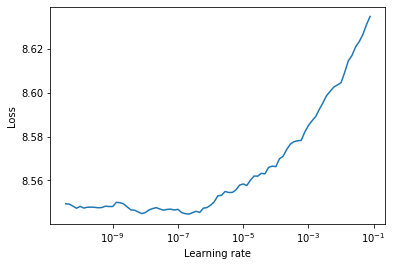

In [22]:
lr_finder.plot()

In [9]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler,num_epochs=25):
    since = time.time()
    FT_losses = []
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}  lr:{}'.format(epoch, num_epochs - 1,optimizer.param_groups[0]['lr']))
        print('-' * 10)    
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode            
            
            running_loss = 0.0
            running_corrects = 0            

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)                
                # zero the parameter gradients
                optimizer.zero_grad()                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                if phase == 'train':
                  FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)         
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())    

            if phase == 'train':
              scheduler.step(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

In [10]:
criterion = nn.CrossEntropyLoss()# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=10, momentum=0.9)# Decay LR by a factor of *gamma* every *step_size* epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.5)
reduceLrOnPlateau_sched = lr_scheduler.ReduceLROnPlateau(optimizer_ft,mode='min',factor =0.1,patience = 3,verbose=True,threshold=0.001 )

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 0/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 6.5822 Acc: 0.2467


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 2.1320 Acc: 0.7255
Epoch 1/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 4.9853 Acc: 0.3837


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 1.2193 Acc: 0.8773
Epoch 2/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 4.1341 Acc: 0.4645


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.7963 Acc: 0.9602
Epoch 3/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 3.4716 Acc: 0.5452


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.5645 Acc: 0.9894
Epoch 4/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 2.9387 Acc: 0.6167


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.4212 Acc: 0.9921
Epoch 5/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 2.4945 Acc: 0.6614


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.3458 Acc: 0.9949
Epoch 6/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 2.1174 Acc: 0.6814


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.2976 Acc: 0.9958
Epoch 7/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 1.7979 Acc: 0.7111


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.2631 Acc: 0.9949
Epoch 8/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 1.5223 Acc: 0.8035


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.2350 Acc: 0.9963
Epoch 9/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 1.2827 Acc: 0.8963


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.2177 Acc: 0.9949
Epoch 10/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 1.0705 Acc: 0.9560


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.2042 Acc: 0.9958
Epoch 11/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.8860 Acc: 0.9826


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1959 Acc: 0.9954
Epoch 12/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.7257 Acc: 0.9930


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1852 Acc: 0.9963
Epoch 13/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.5886 Acc: 0.9968


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1741 Acc: 0.9954
Epoch 14/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.4782 Acc: 0.9978


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1639 Acc: 0.9963
Epoch 15/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.3877 Acc: 0.9983


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1579 Acc: 0.9949
Epoch 16/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.3229 Acc: 0.9989


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1476 Acc: 0.9954
Epoch 17/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2715 Acc: 0.9985


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1397 Acc: 0.9944
Epoch 18/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2275 Acc: 0.9988


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1330 Acc: 0.9949
Epoch 19/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1968 Acc: 0.9989


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1265 Acc: 0.9954
Epoch 20/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1721 Acc: 0.9991


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1223 Acc: 0.9954
Epoch 21/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1535 Acc: 0.9994


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1168 Acc: 0.9949
Epoch 22/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1379 Acc: 0.9993


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1132 Acc: 0.9949
Epoch 23/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1251 Acc: 0.9993


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1091 Acc: 0.9949
Epoch 24/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1147 Acc: 0.9994


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1062 Acc: 0.9958
Epoch 25/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1054 Acc: 0.9993


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1023 Acc: 0.9954
Epoch 26/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0973 Acc: 0.9995


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.1011 Acc: 0.9940
Epoch 27/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0908 Acc: 0.9994


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0977 Acc: 0.9958
Epoch 28/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0851 Acc: 0.9993


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0947 Acc: 0.9958
Epoch 29/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0797 Acc: 0.9993


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0934 Acc: 0.9949
Epoch 30/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0756 Acc: 0.9994


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0910 Acc: 0.9963
Epoch 31/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0712 Acc: 0.9995


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0898 Acc: 0.9958
Epoch 32/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0678 Acc: 0.9994


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0883 Acc: 0.9949
Epoch 33/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0644 Acc: 0.9995


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0859 Acc: 0.9958
Epoch 34/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0615 Acc: 0.9995


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0859 Acc: 0.9949
Epoch 35/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0587 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0846 Acc: 0.9963
Epoch 36/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0564 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0828 Acc: 0.9958
Epoch 37/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0539 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0822 Acc: 0.9954
Epoch 38/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0520 Acc: 0.9995


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0809 Acc: 0.9958
Epoch 39/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0498 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0804 Acc: 0.9954
Epoch 40/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0482 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0785 Acc: 0.9963
Epoch 41/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0469 Acc: 0.9995


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0780 Acc: 0.9958
Epoch 42/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0451 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0768 Acc: 0.9963
Epoch 43/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0434 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0757 Acc: 0.9958
Epoch 44/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0423 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0759 Acc: 0.9958
Epoch 45/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0408 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0747 Acc: 0.9958
Epoch 46/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0396 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0734 Acc: 0.9949
Epoch 47/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0386 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0729 Acc: 0.9958
Epoch 48/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0375 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0724 Acc: 0.9958
Epoch 49/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0364 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0720 Acc: 0.9958
Epoch 50/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0355 Acc: 0.9995


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0717 Acc: 0.9958
Epoch 51/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0349 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0703 Acc: 0.9954
Epoch 52/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0338 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0700 Acc: 0.9954
Epoch 53/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0333 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0696 Acc: 0.9958
Epoch 54/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0322 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0693 Acc: 0.9954
Epoch 55/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0315 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0681 Acc: 0.9954
Epoch 56/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0307 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0685 Acc: 0.9954
Epoch 57/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0301 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0682 Acc: 0.9944
Epoch 58/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0294 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0673 Acc: 0.9954
Epoch 59/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0288 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0671 Acc: 0.9954
Epoch 60/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0283 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0666 Acc: 0.9958
Epoch 61/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0276 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0661 Acc: 0.9958
Epoch 62/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0270 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0659 Acc: 0.9944
Epoch 63/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0268 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0653 Acc: 0.9958
Epoch 64/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0260 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0658 Acc: 0.9949
Epoch 65/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0256 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0652 Acc: 0.9954
Epoch 66/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.9996


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0644 Acc: 0.9958
Epoch 67/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0246 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0639 Acc: 0.9963
Epoch 68/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0241 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0636 Acc: 0.9958
Epoch 69/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0237 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0633 Acc: 0.9958
Epoch 70/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0235 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0629 Acc: 0.9958
Epoch 71/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0230 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0629 Acc: 0.9954
Epoch 72/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0227 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0622 Acc: 0.9958
Epoch 73/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0224 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0627 Acc: 0.9944
Epoch 74/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0220 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0618 Acc: 0.9949
Epoch 75/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0216 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0620 Acc: 0.9958
Epoch 76/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0212 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0617 Acc: 0.9958
Epoch 77/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0209 Acc: 0.9999


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0615 Acc: 0.9958
Epoch 78/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0609 Acc: 0.9963
Epoch 79/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0205 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0612 Acc: 0.9954
Epoch 80/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0200 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0601 Acc: 0.9949
Epoch 81/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0197 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0603 Acc: 0.9963
Epoch 82/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0196 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0602 Acc: 0.9958
Epoch 83/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0192 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0603 Acc: 0.9949
Epoch 84/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0190 Acc: 0.9999


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0599 Acc: 0.9958
Epoch 85/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0187 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0603 Acc: 0.9954
Epoch 86/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0185 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0599 Acc: 0.9963
Epoch 87/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0183 Acc: 0.9997


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0588 Acc: 0.9963
Epoch 88/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0180 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0596 Acc: 0.9954
Epoch 89/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0177 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0589 Acc: 0.9963
Epoch 90/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0175 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0592 Acc: 0.9954
Epoch 91/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0173 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0584 Acc: 0.9963
Epoch 92/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0171 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0584 Acc: 0.9963
Epoch 93/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0168 Acc: 0.9999


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0587 Acc: 0.9949
Epoch 94/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0167 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0582 Acc: 0.9963
Epoch 95/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0165 Acc: 0.9999


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0582 Acc: 0.9968
Epoch 96/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0164 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0578 Acc: 0.9963
Epoch 97/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0162 Acc: 0.9998


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0578 Acc: 0.9954
Epoch 98/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0159 Acc: 0.9999


  0%|          | 0/102 [00:00<?, ?it/s]

val Loss: 0.0580 Acc: 0.9958
Epoch 99/99  lr:10
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.0158 Acc: 0.9999


100%|██████████| 17/17 [00:10<00:00,  1.64it/s]


val Loss: 0.0571 Acc: 0.9963
Training complete in 124m 19s
Best val Acc: 0.996759


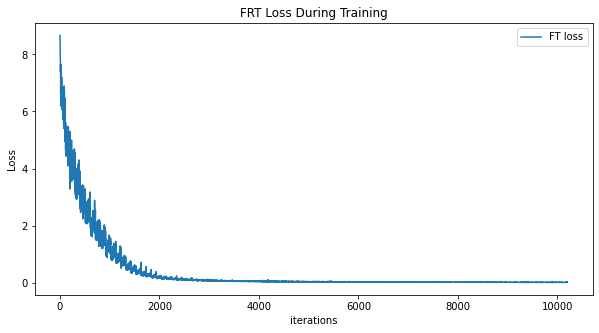

In [11]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, reduceLrOnPlateau_sched, num_epochs=100)

plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
traced_model = torch.jit.trace(model_ft.to('cpu'), torch.randn(1, 3, 160, 160))

In [13]:
traced_model.save('/content/drive/My Drive/e4p2s4/politician_face_reco_model_lr10.pt')